In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import random
from datetime import datetime
MAX_REQUESTS = 1e4
print("imported")
import pandas as pd

imported


In [2]:
from queue import Queue
from threading import Thread
import time


def compute(lambda_, recompute=False, store=True, iterations=1):
    def treat_job(q):
        while True:
            obj = q.get()
            job, s, (t11, t12), (t21,t22) = obj
        
            if job == 1:
                t11 = (datetime.utcnow()-start).total_seconds()*1000
                sleep_time = random.lognormvariate(1.5, 0.6)/1000
                time.sleep(sleep_time)
                t12 = (datetime.utcnow()-start).total_seconds()*1000
                q.put((2, s , (t11, t12), (t21, t22)))

            if job == 2:
                t21 = (datetime.utcnow()-start).total_seconds()*1000
                sleep_time = random.uniform(0.6,1)/1000
                time.sleep(sleep_time)
                t22 = (datetime.utcnow()-start).total_seconds()*1000
                items.append([s , t11, t12, t21, t22])
            q.task_done()
    
    if iterations == 1:
        fname = "data/lambda_{}".format(lambda_)
    else:
        fname = "data/lambda_{}_x{}".format(lambda_, iterations)
    if not recompute:
        try:
            df = pd.read_csv(fname)
            return df
        except FileNotFoundError:
            pass
    num_tasks = 10**4
    labels = ['Start', 'T11', 'T12', 'T21', 'T22']
    df_final = pd.DataFrame(np.zeros((num_tasks, len(labels))), columns=labels)
    for i in range(iterations):
        q = Queue(maxsize=0) 

        worker = Thread(target=treat_job, args=(q,))
        worker.setDaemon(True)
        worker.start()
        start = datetime.utcnow()
        items = []
        for _ in range(num_tasks):
            q.put((1, (datetime.utcnow()-start).total_seconds()*1000, (0, 0), (0,0)))
            time.sleep(random.expovariate(lambda_))
        q.join()

        df = pd.DataFrame(items, columns = labels)
        df_final += df
        print("Finished iteration {} for lambda={}".format(i, lambda_))
    df_final = df_final/iterations
    if store:
        df_final.to_csv(fname, index=False)
    return df

In [3]:
df = compute(80)

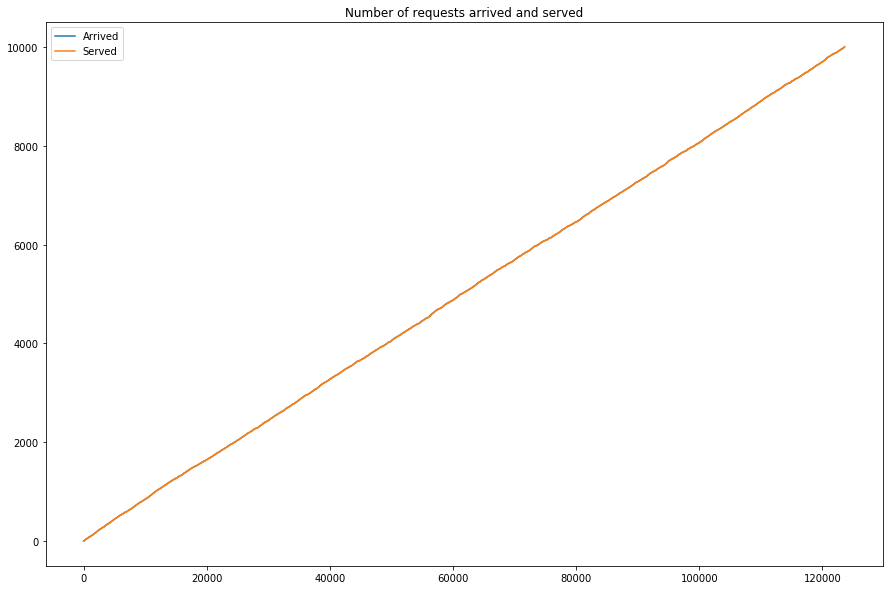

In [4]:
plt.figure(figsize=(15,10))
plt.plot(df['Start'], range(10**4), label="Arrived")
plt.step(df['T22'], range(10**4),label="Served")
plt.title("Number of requests arrived and served")
plt.legend()
plt.show()

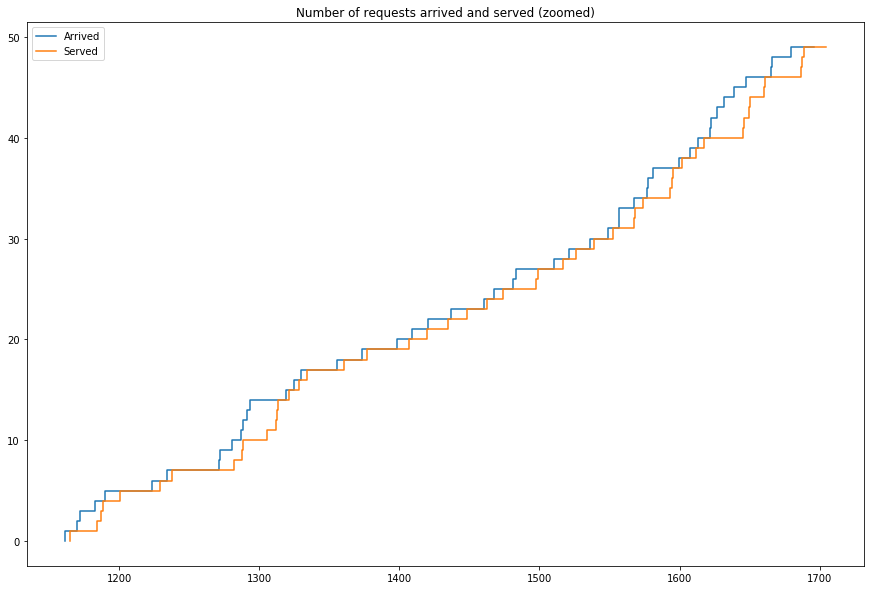

In [5]:
plt.figure(figsize=(15,10))
plt.step(df['Start'][100:150], range(50), label="Arrived")
plt.step(df['T22'][100:150], range(50), label="Served")
plt.title("Number of requests arrived and served (zoomed)")
plt.legend()
plt.show()

In [6]:
def get_type_i_in_queue(df):
    interesting_times = np.sort(np.concatenate((df['Start'].values, df['T12'].values, df['T22'].values)))
    type1_in_queue = []
    type2_in_queue = []
    for t in interesting_times:
        type_ones = df[((df['Start'] - t) <= 0) & ((df['T12'] - t > 0))]
        type_twos = df[((df['T12'] - t) <= 0) & ((df['T22'] - t > 0))]
        type1_in_queue.append(len(type_ones))
        type2_in_queue.append(len(type_twos))
    return interesting_times, type1_in_queue, type2_in_queue

In [7]:
def plot_type_i_in_queue(interesting_times, type1_in_queue, type2_in_queue):
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(2,1,1)
    plt.plot(interesting_times, type1_in_queue, c="C0")
    plt.title("Type 1 in queue")
    fig.add_subplot(2,1,2)
    plt.plot(interesting_times, type2_in_queue, c="orange");
    plt.title("Type 2 in queue")
    plt.tight_layout()
    plt.show()

### average response time (event average)

In [8]:
df['T2-Serv'] = df['T22']-df['T12']
df['T1-Serv'] = df['T12']-df['Start']

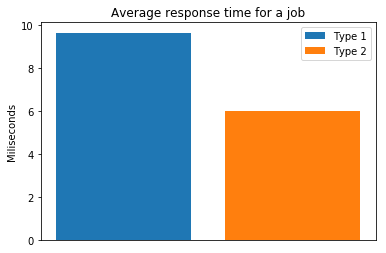

In [9]:
plt.bar([1],[df['T1-Serv'].mean()], label="Type 1")
plt.bar([2],[df['T2-Serv'].mean()], label="Type 2")
plt.title("Average response time for a job")
plt.xticks([])
plt.ylabel('Miliseconds')
plt.legend();

### Average number of jobs served per second

In [10]:
served = []
for sample_start_time in (df.values.max()-1000)*np.random.sample(100):
    served.append(df[(df['T21'] > sample_start_time) & (df['T22'] < sample_start_time+1000)].count()['Start'])
print("Average number of Type 1 jobs served per second: {}".format(np.mean(served)))

Average number of Type 1 jobs served per second: 81.03


In [11]:
served = []
for sample_start_time in (df.values.max()-1000)*np.random.sample(50):
    served.append(df[(df['T11'] > sample_start_time) & (df['T12'] < sample_start_time+1000)].count()['Start'])
print("Average number of Type 2 jobs served per second: {}".format(np.mean(served)))

Average number of Type 2 jobs served per second: 79.9


As we see, the number of jobs served per second is in both cases close to 80, as the server can keep up with the requests rate, of 80 requests/seconds. So the queue being most of the time almose empty, the rate is obviously close to 80.

# 2

In [ ]:
lambdas = np.arange(25, 250, 25)
queues = []

In [ ]:
items = []
#for l in lambdas: 
#    it = compute(l)
#    items.append(it)

In [ ]:
#for i in range(len(items)): 
#    df = pd.DataFrame(items[i], columns = ['Start', 'T11', 'T12', 'T21', 'T22'])
#    df.to_csv("lambda_"+str(25*(i+1)), index=False)

# 3 Remove Transients

## $\lambda = 60$

In [15]:
df60 = compute(60)

In [16]:
interesting_times60, type1_in_queue_60, type2_in_queue_60 = get_type_i_in_queue(df60)

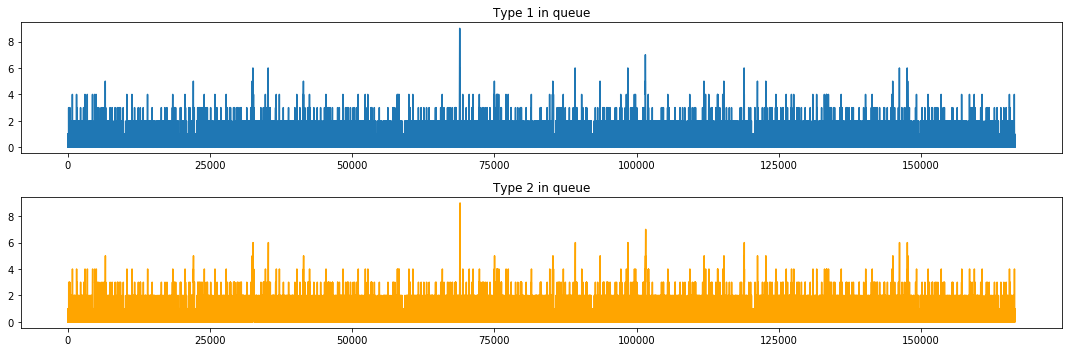

In [17]:
plot_type_i_in_queue(interesting_times60, type1_in_queue_60, type2_in_queue_60)

### CI for median

In [18]:
def ci_median(n):
    lower_ind = np.floor(n/2 - 0.98*np.sqrt(n))
    higher_ind = np.ceil(n/2 + 0.98*np.sqrt(n) + 1)
    return int(lower_ind), int(higher_ind)

In [20]:
l,h = ci_median(len(interesting_times60))
a = np.sort(type2_in_queue_60)
print("The median for lambda=60 is, with 95% confidence, between {} and {}".format(a[l], a[h]))

The median is, with 95% confidence, between 0 and 1


### $\lambda = 160$

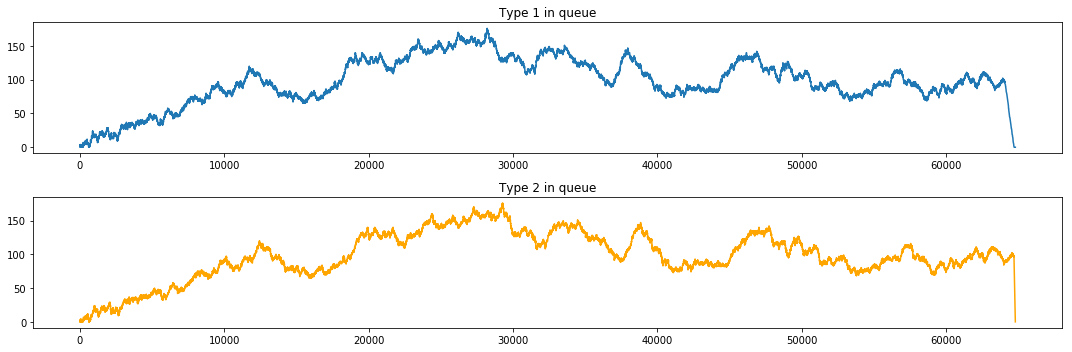

In [21]:
df160 = compute(160)
interesting_times160, type1_in_queue_160, type2_in_queue_160 = get_type_i_in_queue(df160)
plot_type_i_in_queue(interesting_times160, type1_in_queue_160, type2_in_queue_160)

In [ ]:
l,h = ci_median(len(interesting_times60))
a = np.sort(type2_in_queue_160)
print("The median for lambda=160 is, with 95% confidence, between {} and {}".format(a[l], a[h]))